<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/Plant-disease/blob/master/DeteksiPenyakit_tanaman_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Plant Disease Diagnosis Model with PlantVillage Dataset



In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
# Use TensorFlow settings
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)
# Keras imports
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import get_file
# Ensure consistent data handling with Keras
from sklearn.model_selection import train_test_split



# Persiapan

## Pengambilan Data 

In [11]:
!apt-get install subversion > /dev/null

#Retreive specifc diseases of tomato for training
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Bacterial_spot image/Tomato___Bacterial_spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Early_blight image/Tomato___Early_blight　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Late_blight image/Tomato___Late_blight　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Septoria_leaf_spot image/Tomato___Septoria_leaf_spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Target_Spot image/Tomato___Target_Spot　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___healthy image/Tomato___healthy　>  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Tomato_mosaic_virus image/Tomato___mosaic_virus >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Spider_mites%20Two-spotted_spider_mite image/Tomato___Spider_mites_20Two-spotted_spider_mite >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Leaf_Mold image/Tomato___Leaf_Mold >  /dev/null
!svn export https://github.com/spMohanty/PlantVillage-Dataset/trunk/raw/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus image/Tomato___Yellow_Leaf_Curl_Virus >  /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cbb image/Cassava___cbb > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cbsd image/Cassava___cbsd > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cgm image/Cassava___cgm > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/cmd image/Cassava___cmd > /dev/null
!svn export https://github.com/icassava/fgvcx-icassava/trunk/data/train/healthy image/Cassava___healthy > /dev/null

The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.


In [8]:
#folder structure
!ls image

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
plt.figure(figsize=(15,10))

#visualize several images

parent_directory = "image"

for i, folder in enumerate(os.listdir(parent_directory)):
    print(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    file = files[0] 
    file_path = os.path.join(folder_directory,file)
    
    image = imread(file_path)
    plt.subplot(1,15,i+1)
    plt.imshow(image)
    plt.axis("off")
    
    name = folder.split("___")[1][:-1]
    plt.title(name)
    plt.show()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'image'

<Figure size 1500x1000 with 0 Axes>

In [5]:
#load everything into memory
x = []
y = []
class_names = []
parent_directory = "image"

for i,folder in enumerate(os.listdir(parent_directory)):
    print(i,folder)
    class_names.append(folder)
    folder_directory = os.path.join(parent_directory,folder)
    files = os.listdir(folder_directory)
    #will inspect only 1 image per folder
    for file in files:
        file_path = os.path.join(folder_directory,file)
        image = load_img(file_path,target_size=(75,75))
        image = img_to_array(image)/255.
        x.append(image)
        y.append(i)

x = np.array(x)
y = to_categorical(y)

0 Tomato___Late_blight　
1 Tomato___Septoria_leaf_spot　
2 Tomato___Leaf_Mold
3 Tomato___Target_Spot　
4 Tomato___healthy　
5 Tomato___Early_blight　
6 Tomato___Bacterial_spot　
7 Tomato___Yellow_Leaf_Curl_Virus
8 Tomato___Spider_mites_20Two-spotted_spider_mite
9 Cassava___cmd
10 Cassava___cbsd
11 Cassava___healthy
12 Cassava___cgm
13 Tomato___mosaic_virus
14 Cassava___cbb


In [6]:
#check the data shape
print(x.shape)
print(y.shape)
print(y[0])

(23816, 75, 75, 3)
(23816, 15)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
x_train, _x, y_train, _y = train_test_split(x,y,test_size=0.2, stratify = y, random_state = 1)
x_valid,x_test, y_valid, y_test = train_test_split(_x,_y,test_size=0.4, stratify = _y, random_state = 1)

print("train data:",x_train.shape,y_train.shape)
print("validation data:",x_valid.shape,y_valid.shape)
print("test data:",x_test.shape,y_test.shape)


train data: (19052, 75, 75, 3) (19052, 15)
validation data: (2858, 75, 75, 3) (2858, 15)
test data: (1906, 75, 75, 3) (1906, 15)


In [8]:
import tensorflow as tf
IMG_SHAPE = (75, 75, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
base_model.trainable = True
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Model Preparation

In [10]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(15, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7695      
Total params: 22,859,567
Trainable params: 22,825,135
Non-trainable params: 34,432
_________________________________________________________________


## Training

In [0]:
#utilize early stopping function to stop at the lowest validation loss
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
#utilize save best weight model during training
ckpt = ModelCheckpoint("DeteksiPenyakitTanaman.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [0]:
#we will define a generator class for training data and validation data seperately, as no augmentation is not required for validation data
t_gen = ImageDataGenerator(rotation_range=90,horizontal_flip=True)
v_gen = ImageDataGenerator()
train_gen = t_gen.flow(x_train,y_train,batch_size=98)
valid_gen = v_gen.flow(x_valid,y_valid,batch_size=98)

In [13]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.n // 98,
    #callbacks = [ckpt],
    callbacks = [es,ckpt],
    validation_data = valid_gen,
    validation_steps = valid_gen.n // 98,
    
    epochs=100 #@param {type:"integer"}
)

Epoch 1/100
 29/194 [===>..........................] - ETA: 16s - loss: 2.3240 - acc: 0.3783
Epoch 00001: val_loss improved from inf to 2.32404, saving model to DeteksiPenyakitTanaman.hdf5
194/194 [==============================] - 55s 286ms/step - loss: 1.6463 - acc: 0.4844 - val_loss: 2.3240 - val_acc: 0.3783
Epoch 2/100
 29/194 [===>..........................] - ETA: 5s - loss: 1.6229 - acc: 0.4071
Epoch 00002: val_loss improved from 2.32404 to 1.62290, saving model to DeteksiPenyakitTanaman.hdf5
194/194 [==============================] - 33s 169ms/step - loss: 0.9388 - acc: 0.6958 - val_loss: 1.6229 - val_acc: 0.4071
Epoch 3/100
 29/194 [===>..........................] - ETA: 5s - loss: 21.0208 - acc: 0.4796
Epoch 00003: val_loss did not improve from 1.62290
194/194 [==============================] - 32s 164ms/step - loss: 0.7558 - acc: 0.7510 - val_loss: 21.0208 - val_acc: 0.4796
Epoch 4/100
 29/194 [===>..........................] - ETA: 6s - loss: 3.1263 - acc: 0.5535
Epoch 0000

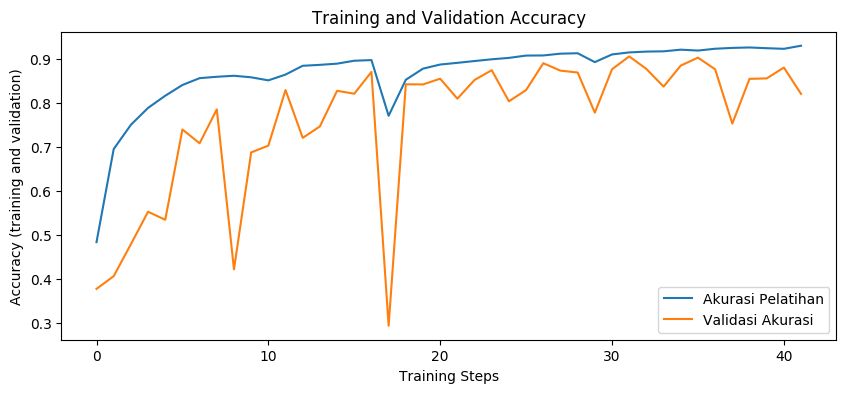

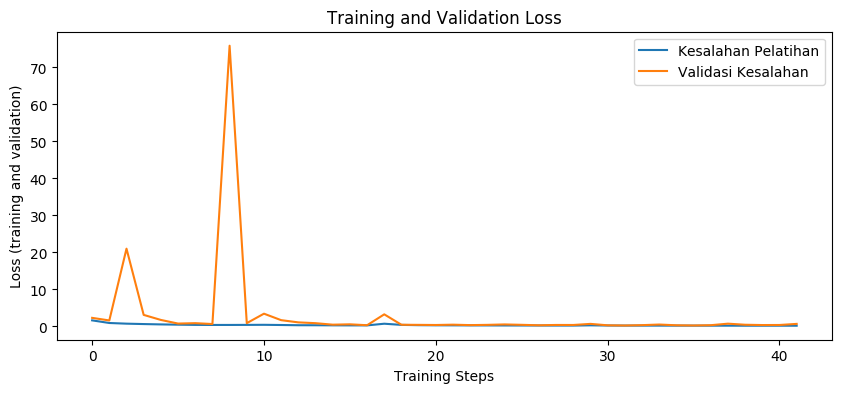

In [14]:
plt.figure(figsize=(10, 4))
#plt.subplot(1, 5, 4)
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.show()
plt.figure(figsize=(10, 4))
#plt.subplot(1, 3, 2)
plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

## Evaluation

In [0]:
#load the model weight file with lowest validation loss
model.load_weights("DeteksiPenyakitTanaman.hdf5")

In [16]:
#check the model metrics
print(model.metrics_names)
#evaluate training data
print(model.evaluate(x= x_train, y = y_train))
#evaluate  validation data
print(model.evaluate(x= x_valid, y = y_valid))
#evaluate  test data
print(model.evaluate(x= x_test, y = y_test))      

['loss', 'acc']
19052/19052 [==============================] - 12s 638us/sample - loss: 0.2252 - acc: 0.9178
[0.22520366611255208, 0.91775143]
2858/2858 [==============================] - 2s 696us/sample - loss: 0.2541 - acc: 0.9066
[0.2540657081288671, 0.906578]
1906/1906 [==============================] - 1s 739us/sample - loss: 0.2826 - acc: 0.8998
[0.28261436869127426, 0.8997901]


In [17]:
#draw a confusion matrix

#true label
y_true = np.argmax(y_test,axis=1)

#prediction label
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[5 6 9 ... 7 7 7]
[5 6 9 ... 7 7 7]


Normalized confusion matrix
[[0.99 0.   0.   0.   0.   0.01 0.   0.   0.01 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.94 0.02 0.01 0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.01
  0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.01 0.   0.95 0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.04 0.01 0.03 0.03 0.   0.9  0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.01 0.   0.01 0.   0.07 0.89 0.02 0.01 0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.01 0.   0.   0.   0.97 0.   0.   0.   0.   0.02
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.76 0.17 0.01 0.05 0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.81 0.01 0.03 0.
  0.1 ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.08 0.24 0.4  0.2  0.
  0.08]
 [0.   0.   0.   0.   0.   0.   

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0.0, flags=flags)


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 12288 missing from current font.
  font.set_text(s, 0, flags=flags)


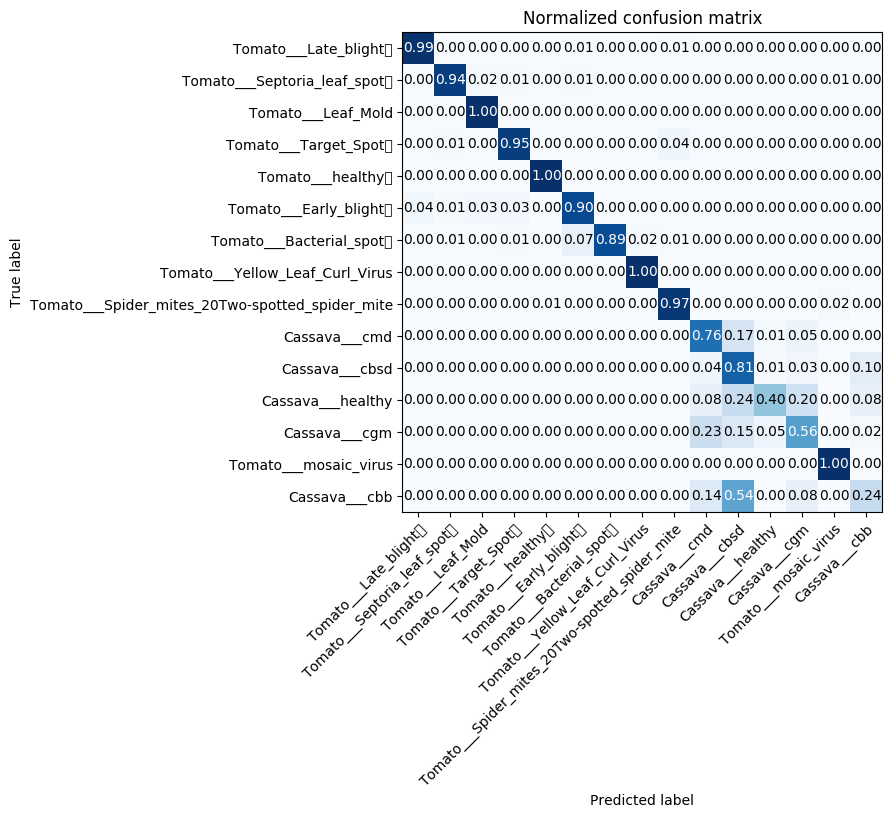

In [18]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')



## Predicting Indivisual Images

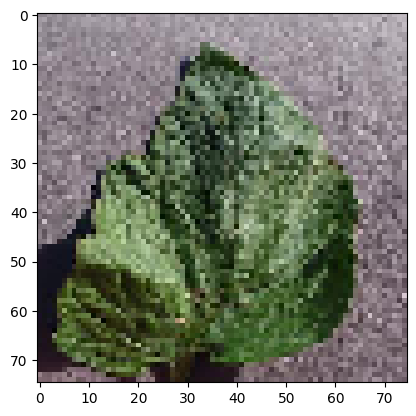

Gambar Yang Benar Adalah: 3 : Tomato___Target_Spot　
prediksi Value: [6.15e-06 9.19e-06 1.05e-06 9.99e-01 1.36e-04 9.01e-06 4.31e-05 6.08e-08
 3.25e-04 1.21e-07 4.72e-07 1.31e-10 3.90e-07 2.28e-07 6.20e-09]
prediksi gambar: 3 : Tomato___Target_Spot　
Prediksi Benar


In [19]:
n = 23 #do not exceed (number of test image - 1)

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test,axis=1)[n]
print("Gambar Yang Benar Adalah:",true_label,":",class_names[true_label])
prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("prediksi Value:",prediction)
predicted_label = np.argmax(prediction)
print("prediksi gambar:",predicted_label,":",class_names[predicted_label])

if true_label == predicted_label:
    print("Prediksi Benar")
else:
    print("Prediksi Salah")

In [20]:
keras_file = "DeteksiPenyakitTanaman.hdf5"
tf.keras.models.save_model(model, keras_file)

# Convert to TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("DeteksiPenyakitTanamanMoNet.tflite", "wb").write(tflite_model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 380 variables.
INFO:tensorflow:Converted 380 variables to const ops.


91340040